In [19]:
# 패키지 임포트
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from scipy.optimize import minimize

sns.set()

### 데이터셋 준비
ETF에 대한 가격 데이터 (월간 단위 데이터)

In [23]:
# ETF 데이터 다운로드
tickers = ['XLB', 'XLE', 'XLF', 'XLI', 'XLK', 'XLP', 'XLU', 'XLV', 'XLY']
etf = yf.Tickers(tickers)
data = etf.history(start='2010-01-01', actions=False)
data.drop(['Open', 'High', 'Low', 'Volume'], inplace=True, axis=1)
data = data.droplevel(0, axis=1).resample('M').last()

[*********************100%***********************]  9 of 9 completed


In [24]:
# 수익률
rets = data.pct_change().fillna(0)

In [25]:
# 색깔 팔레트
pal = sns.color_palette('Spectral', len(tickers))

### 샤프비율 최대화를 위한 최적화 알고리즘 구현

In [26]:
# 초기값 설정
noa = rets.shape[1]
init_guess = np.repeat(1/noa, noa)

# 기대수익률 벡터
er = rets.mean() * 12

# 공분산행렬
cov = rets.cov() * 12

# 각 ETF별 투자 가중치 상하한선 : 공매도 불가 조건
bounds = ((0.0, 1.0), ) * noa

# 제약조건 : 전체 가중치의 합이 1, 레버리지 불가 조건
weights_sum_to_1 = {'type': 'eq',
                    'fun': lambda weights: np.sum(weights) - 1}

# 목적함수 : 마이너스 샤프비율
def neg_sharpe(weights, er, cov):
    r = weights.T @ er
    vol = np.sqrt(weights.T @ cov @ weights)
    return - r / vol

# 최적화 알고리즘 구동
res = minimize(neg_sharpe,
               init_guess,
               args=(er, cov),
               method='SLSQP',
               constraints=(weights_sum_to_1,),
               bounds=bounds)

# 가중치 결과값
weights = res.x

# 결과 출력
print(weights)

[1.84314348e-18 1.24521104e-16 1.26912334e-17 0.00000000e+00
 3.30630894e-01 7.09744770e-02 2.66763527e-01 3.31631103e-01
 0.00000000e+00]


### 샤프비율 최대화 포트폴리오 파이차트 시각화

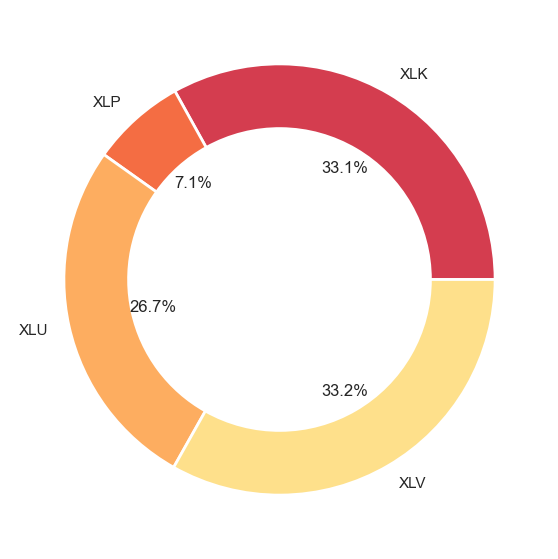

In [27]:
# 가중치 데이터프레임 생성
weghts_df = pd.Series(np.round(weights, 3), index=tickers)
weghts_df = weghts_df[weghts_df > 0.0]

# 파이차크 시각화
plt.figure(figsize=(7, 7))
wedgeprops = {'width': 0.3, 'edgecolor': 'w', 'linewidth': 2}
plt.pie(weghts_df, labels=weghts_df.index, autopct='%.1f%%', wedgeprops=wedgeprops, colors=pal)
plt.show()

In [28]:
# MSR 모델 가중치 계산 함수
def get_msr_weights(er, cov):

    # 자산 개수
    noa = er.shape[0]

    # 초기 가중치
    init_guess = np.repeat(1/noa, noa)

    # 제약조건 및 상하한값
    bounds = ((0.0, 1.0), ) * noa
    weights_sum_to_1 = {'type': 'eq',
                        'fun': lambda weights: np.sum(weights) - 1}

    # 목적함수: 마이너스 샤프비율
    def neg_sharpe(weights, er, cov):
        r = weights.T @ er
        vol = np.sqrt(weights.T @ cov @ weights)
        return - r / vol

    # 최적화 수행
    res = minimize(neg_sharpe,
                   init_guess,
                   args=(er, cov),
                   method='SLSQP',
                   constraints=(weights_sum_to_1,),
                   bounds=bounds)

    return res.x

In [29]:
# 빈 데이터프레임 생성
msr_w_df = pd.DataFrame().reindex_like(rets)

# 기대수익률 배열
er = np.array(rets * 12)

# 공분산행렬 배열
cov = rets.rolling(12).cov().fillna(0) * 12
cov = cov.values.reshape(int(cov.shape[0] / cov.shape[1]), cov.shape[1], cov.shape[1])

for i in range(12, len(msr_w_df)):
    msr_w_df.iloc[i] = get_msr_weights(er[i-1], cov[i-1])

In [30]:
msr_w_df

,XLB,XLE,XLF,XLI,XLK,XLP,XLU,XLV,XLY
Date,,,,,,,,,
2010-01-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-02-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-03-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-04-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-05-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
2022-10-31,1.202022e-09,1.505850e-09,1.146693e-09,1.106246e-09,1.169813e-09,8.368929e-10,1.108954e-09,1.000000,1.530197e-08
2022-11-30,0.000000e+00,3.588629e-01,0.000000e+00,0.000000e+00,1.413090e-15,3.314937e-01,2.262758e-15,0.309643,3.230800e-17
2022-12-31,1.000000e+00,2.831069e-15,0.000000e+00,0.000000e+00,3.885781e-16,0.000000e+00,0.000000e+00,0.000000,6.050715e-15


### 샤프비율 최대화 포트폴리오 시계열 가중치 플랏 생성

Text(0, 0.5, 'Weights')

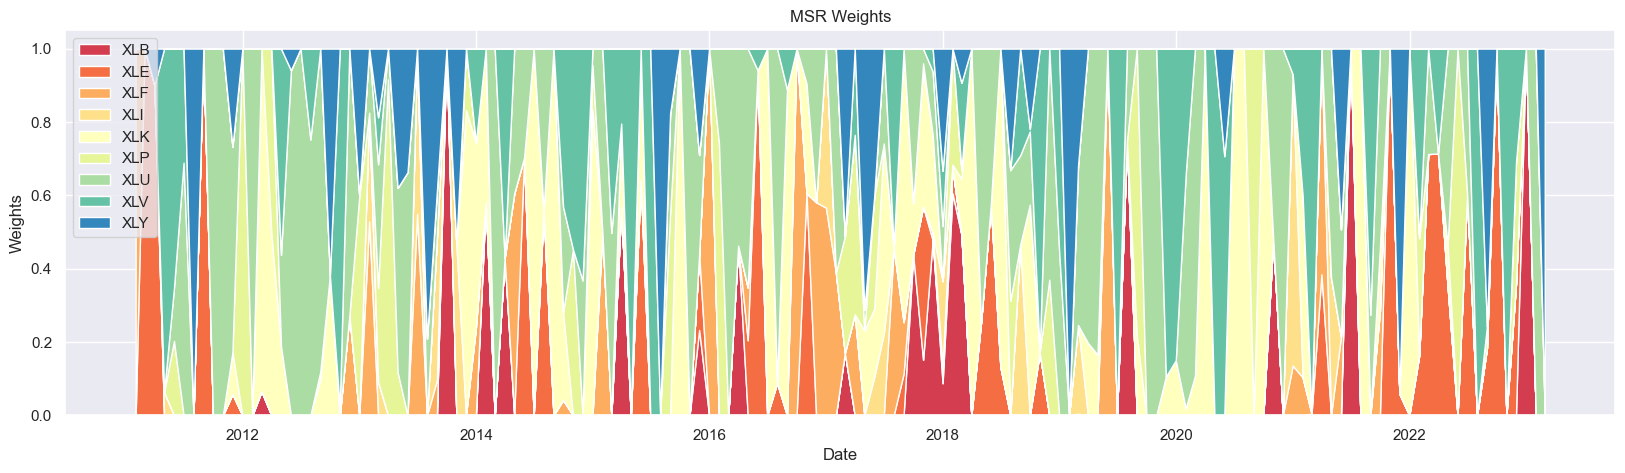

In [31]:
# 가중치 시계열 플랏
plt.figure(figsize=(20, 5))
plt.stackplot(msr_w_df.index, msr_w_df.T, labels=msr_w_df.columns, colors=pal)
plt.legend(loc='upper left')
plt.title('MSR Weights')
plt.xlabel('Date')
plt.ylabel('Weights')

### 샤프비율 최대화 포트폴리오 백테스팅 결과

Text(0, 0.5, 'Returns')

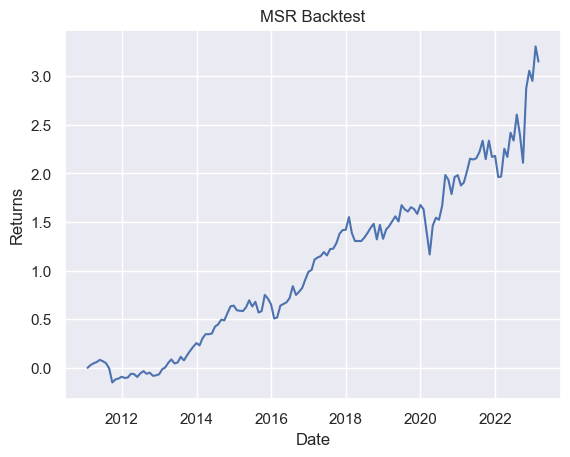

In [32]:
# 포트폴리오 수익률 데이터프레임
port_rets = msr_w_df.shift() * rets
port_cum_rets = (1 + port_rets.sum(axis=1)).cumprod() - 1

# MSR 백테스팅 시각화
plt.plot(port_cum_rets.iloc[12:])
plt.title('MSR Backtest')
plt.xlabel('Date')
plt.ylabel('Returns')